<a href="https://colab.research.google.com/github/Joyfull-Joyal/sign_language_interprter_Main-Project/blob/test/Interprter_ReNet50_epoch_80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 2320 images belonging to 29 classes.
Found 290 images belonging to 29 classes.
Found 290 images belonging to 29 classes.
Epoch 1/80
145/145 [==============================] - 552s 4s/step - loss: 1.6180 - accuracy: 0.5780 - val_loss: 1.4960 - val_accuracy: 0.6285
Epoch 2/80
145/145 [==============================] - 41s 279ms/step - loss: 0.6449 - accuracy: 0.8306 - val_loss: 1.2171 - val_accuracy: 0.7188
Epoch 3/80
145/145 [==============================] - 40s 277ms/step - loss: 0.4420 - accuracy: 0.8948 - val_loss: 1.1218 - val_accuracy: 0.7118
Epoch 4/80
145/145 [==============================] - 40s 278ms/step - loss: 0.3641 - accuracy: 0.9043 - val_loss: 1.1124 - val_accuracy: 0.7812
Epoch 5/80
145/145 [==============================] - 40s 277ms/step - loss: 0.3175 - accuracy: 0.9116 - val_loss: 1.0167 - val_accuracy: 0.8090
Epoch 6/80
145/145 [==============================] - 41s 284ms/step - loss: 0.2607 - accuracy: 0.9284 - val_loss: 1.0877 - val_accuracy: 0.7708
Epoch

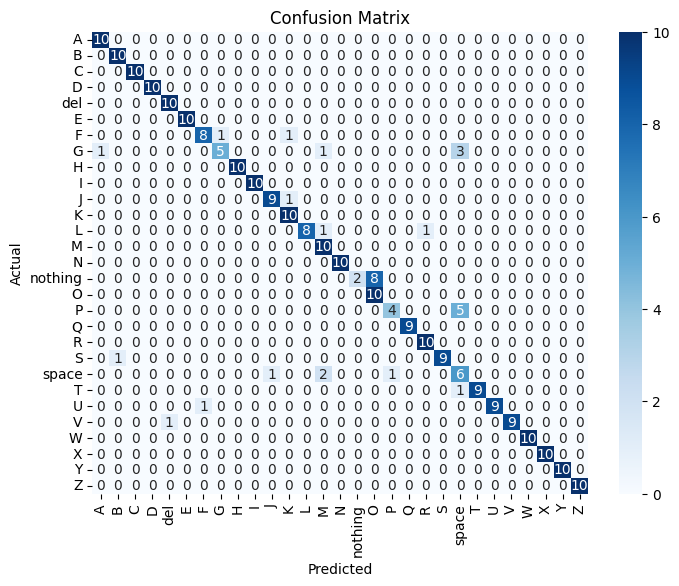

Test loss: 0.5108
Test accuracy: 89.24
Train loss: 0.0525
Train accuracy: 98.32
Recall: 0.89
Precision: 0.92
F1-score: 0.89
RMSE: 2.73


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/Dataset/Dataset3.0/train'
val_dir = '/content/drive/MyDrive/Dataset/Dataset3.0/validation'
test_dir = '/content/drive/MyDrive/Dataset/Dataset3.0/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16

# Create data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a dense layer for classification
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(29, activation='softmax')(x)  # Assuming 29 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=80,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], yticklabels=['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'RMSE: {rmse:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/Project/Modeltest/sign_language_interprter_ReNet50_epoch_80.h5')